## Example of Retrieving an SDO/HMI and Getting Solar Heliocentric Coordinates

Load necessary modules

In [2]:
import sunpy.map
import sunpy.data.sample
import astropy.units as u
import numpy as np
from datetime import datetime, timedelta, timezone
import time as time

# packages needed for displaying and retrieving mouse click info
#%matplotlib tk
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox,  CheckButtons
import matplotlib.colors as colors
from matplotlib.lines import Line2D

# packages needed to perform searches of online archives
from sunpy.net import jsoc
from sunpy.net import Fido, attrs as a
import drms
setemail = a.jsoc.Notify('kreardon@nso.edu')

import inspect

ModuleNotFoundError: No module named 'sunpy'

If there is a local SDO/HMI (or other file) that should be used, define the name of the file (with the appropriate path) here.

In [8]:
path           = './'
local_hmi_file = path + 'hmi.Ic_45s.20210511_175145_TAI.2.continuum.fits'
#local_hmi_file = path + 'hmi.ic_45s.2015.12.17_19_17_15_TAI.continuum.fits'
use_local_file = 0

To look for recent files we will set up a temporal search range covering the past 24 hours.

In [21]:
current_time = datetime.now(timezone.utc)
yesterday_time = current_time - timedelta(1)
search_range = a.Time(yesterday_time, current_time)
print("Search Start Time - ",search_range.min.strftime("%Y-%m-%d %H:%M:%S UT"))
print("Search End Time   - ",search_range.max.strftime("%Y-%m-%d %H:%M:%S UT"))

Search Start Time -  2023-12-10 06:33:39 UT
Search End Time   -  2023-12-11 06:33:39 UT


In [22]:
#series = a.jsoc.Series.aia_lev1
series = a.jsoc.Series.hmi_ic_nolimbdark_720s_nrt
print("Searching JSOC Series:", series.value)
last_day_results = Fido.search(search_range,series,a.jsoc.Notify('kreardon@nso.edu'))
result_count = len(last_day_results[0,:])
print("Found ",result_count, "matching records.")

Searching JSOC Series: hmi.ic_nolimbdark_720s_nrt
Found  117 matching records.


We don't want to download the dozens or hundreds of files acquired over the last 24 hours, so we'll take the time of the newest and second newest image and redo the search to just return the record for the latest file.

In [23]:
result_2nd_newest = last_day_results[0,result_count-2]
result_newest = last_day_results[0,result_count-1]

print('The newest image is from    ',result_newest['DATE-OBS'])
print('The 2nd newest image is from',result_2nd_newest['DATE-OBS'])
print('The current time is         ',datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%S.%f")[:-7], 'UT')


#latest_time_range = a.Time(result_2nd_newest['DATE-OBS'], result_newest['DATE-OBS'])
latest_time_range = a.Time(result_newest['DATE-OBS'], current_time)
# this is one way to do the search
#latest_image_result = Fido.search(latest_time_range,series,a.jsoc.Notify('kreardon@nso.edu'))
# but this is a different approach that breaks down the search and retrieval into several components.
client = jsoc.JSOCClient()  
latest_image_result = client.search(latest_time_range,series,a.jsoc.Notify('kreardon@nso.edu'))

The newest image is from     2023-12-11T05:46:30.50Z
The 2nd newest image is from 2023-12-11T05:34:30.50Z
The current time is          2023-12-11T06:33:48 UT


In [24]:
# if we use the Fido.search approach above, we will need to perform a slicing of the results
#print("Found ",len(latest_image_result[0,:]), "matching records")
#print((latest_image_result[0,:])['DATE-OBS'])
# but if we use the client.search method, we don't need to do any slicing
print("Found ",len(latest_image_result), "matching records")
print((latest_image_result)['DATE-OBS'])

Found  1 matching records
        DATE-OBS       
-----------------------
2023-12-11T05:46:30.50Z


If this is a valid and useful record, we can execute the data retrieval request.

In [25]:
# This command actually executes the data request on the remote archive 
# (and will result in an email to the address specified in the a.jsoc.Notify above).
requests = client.request_data(latest_image_result)  

Now we will wait for the data file to be staged on the remote server, ready for download. We will poll the status of the request, waiting for it to got to Status=0, indicating the download is ready (sometimes it is ready even before the request status changes here, but that's hard to know.

In [30]:
print("JSOC Request ID:    ",requests.id)
print("JSOC Request Status:", requests.status)
wait_time = 10 # seconds
wait_max  = 60 # maximum time to wait
counter = 0
counter_max = wait_max / wait_time
print("waiting for JSOC [elapsed sec] - ", end="")
while (requests.status != 1) & (counter <= counter_max) :
    print(counter * wait_time , end=" ")
    time.sleep(wait_time)
    counter += 1
#    if (counter == counter_max):
#        break
print()
print("JSOC Request Status:", requests.status)
print("Wait time =", counter * wait_time, "sec")

JSOC Request ID:     JSOC_20231211_742
JSOC Request Status: 0
waiting for JSOC [elapsed sec] - 
JSOC Request Status: 0
Wait time = 0 sec


Now we perform the actual data transfer to the local machine.

In [29]:
retrieved_data_file = client.get_request(requests, downloader=None, progress=True)  
print("JSOC Request ID:    ",requests.id)
print("JSOC Request Status:", requests.status)
#retrieved_data_file.wait(progress=True)   

JSOC Request ID:     JSOC_20231211_742
JSOC Request Status: 1
1 URLs found for download. Full request totalling 16MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

hmi.ic_nolimbdark_720s_nrt.20231211_054800_TAI.3.continuum.fits:   0%|          | 0.00/16.5M [00:00<?, ?B/s]

JSOC Request ID:     JSOC_20231211_742
JSOC Request Status: 0


This is the name and path of the downloaded file.

In [117]:
print("Downloaded File: ",retrieved_data_file)

Downloaded File:  ['/Users/kreardon/sunpy/data/hmi.ic_nolimbdark_720s_nrt.20231211_043600_TAI.3.continuum.fits']


Which we can now download into a map object that allows us to better manage the file.

In [31]:
if use_local_file == 1:
    my_map = sunpy.map.Map(local_hmi_file)
else:
    my_map = sunpy.map.Map(retrieved_data_file)

# map usually needs to be rotated so solar north is up
my_map = my_map.rotate()

Observatory,SDO
Instrument,HMI COMBINED
Detector,HMI
Measurement,continuum
Wavelength,6173.0 Angstrom
Observation Date,2023-12-11 05:46:30
Exposure Time,Unknown
Dimension,[4098. 4098.] pix
Coordinate System,helioprojective
Scale,[0.50402981 0.50402981] arcsec / pix
Reference Pixel,[2055.75164964 2050.32263311] pix

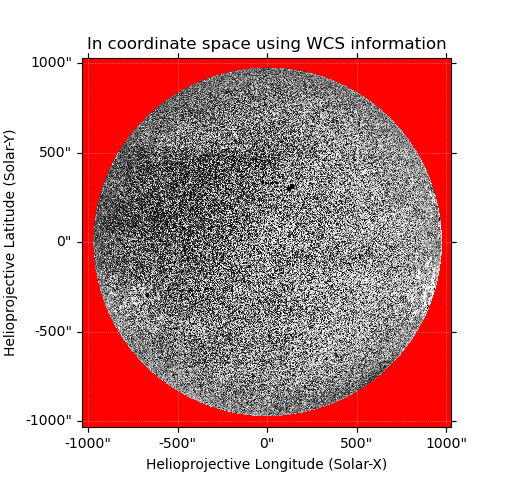
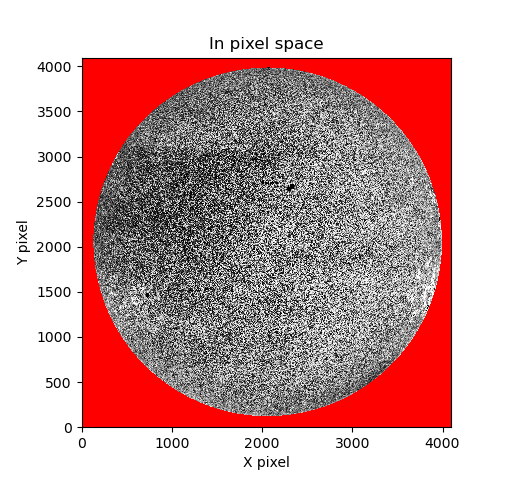
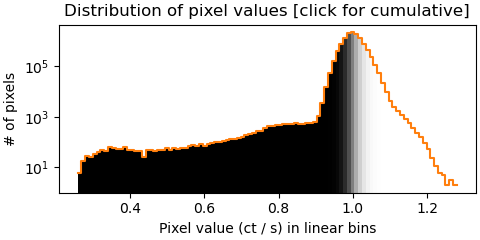
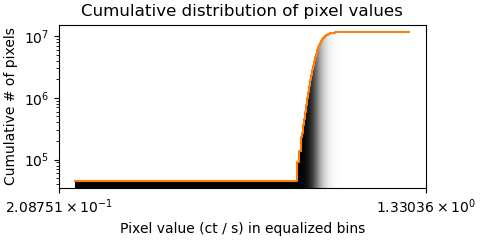

In [32]:
my_map

In [33]:
my_map.coordinate_frame

<Helioprojective Frame (obstime=2023-12-11T05:46:30.500, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2023-12-11T05:46:30.500, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01145244, -0.36865562, 1.4735283e+11)>)>

Define a coupile of routines that will get the pixel coordinates (an event handler) and convert those pixels to World Coordinates (WCS) for arcseconds (i.e. helioprojective).

In [ ]:
def get_clicked_skycoord(event):
    ix, iy = event.xdata, event.ydata
    clicked_skycoord = my_map.pixel_to_world(ix * u.pix, iy * u.pix)
    #print(clicked_skycoord)
    coord_x = f"{clicked_skycoord.Tx:5.2f}"
    coord_y = f"{clicked_skycoord.Ty:5.2f}"
    print('Clicked sun coordinates   - x: {} and y: {}'.format(coord_x, coord_y))
    return clicked_skycoord

In [70]:
def onclick(event):
    if event.xdata != None:
        coord_pix_x =  f"{event.xdata:7.2f}"
    else:
        coord_pix_x = "OutofBounds"

    if event.ydata != None:
        coord_pix_y =  f"{event.ydata:7.2f}"
    else:
        coord_pix_y = "OutofBounds"
    
    print('Clicked pixel coordinates - x: {}        and y: {}'.format(coord_pix_x, coord_pix_y))

    clicked_skycoord = get_clicked_skycoord(event)
    #print(event)

    return clicked_skycoord
#cid1 = fig.canvas.mpl_connect('button_press_event', onclick)
#cid2 = fig.canvas.mpl_connect('pick_event', pick_los_point)

In [74]:
%matplotlib tk
fig = plt.figure()
cid1 = fig.canvas.mpl_connect('button_press_event', onclick)
ax = fig.add_subplot(projection=my_map)
my_map.plot(axes=ax)
plt.colorbar()
plt.show()

Clicked pixel coordinates - x: 2236.99        and y: 2219.25
Clicked sun coordinates   - x: 91.35 arcsec and y: 85.14 arcsec
Clicked pixel coordinates - x: 2769.20        and y: 2130.55
Clicked sun coordinates   - x: 359.60 arcsec and y: 40.44 arcsec
Clicked pixel coordinates - x: 3833.61        and y: 2064.02
Clicked sun coordinates   - x: 896.09 arcsec and y:  6.91 arcsec
Clicked pixel coordinates - x: 1815.66        and y: 2363.39
Clicked sun coordinates   - x: -121.01 arcsec and y: 157.80 arcsec


In [72]:
clicked_skycoord = 100.1234567
print(f"{clicked_skycoord:5.2}")

100.12
